## THIS STUDIES DATA DURING CAMPA_18 DAY 587 - 642

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [3]:
dir_path = 'Kroger_Retail_Dunnhumby/'

file1= dir_path + 'transaction_data.csv'
file2 = dir_path + 'hh_demographic.csv'
file3 = dir_path + 'coupon_redempt.csv'
file4= dir_path + 'coupon.csv'
file5 = dir_path + 'campaign_desc.csv'
file6 = dir_path + 'campaign_table.csv'
# file7= dir_path + 'causal_data.csv'
file8 = dir_path + 'product.csv'


In [4]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower()
    return df
    

In [5]:
# import data into dataframe

df_trans_full = load_data(file1)
df_cus = load_data(file2)
df_coupon_redempt_full = load_data(file3)
df_coupon_full = load_data(file4)
df_camp_cus_full = load_data(file6)
# df_prod_causal = load_data(file7)
df_prod = load_data(file8)

df_campaign_detail = pd.read_csv('DATA_CLEAN/campaign_details.csv')


In [6]:
# data during campA 18 - day 587 to 642
df_trans = df_trans_full[(df_trans_full.day>=587) & (df_trans_full.day<=642)]
print('Total trans', df_trans_full.shape)
df_trans.shape

Total trans (2595732, 12)


(233860, 12)

In [7]:
# data during campA 18 - day 587 to 642
df_coupon_redempt = df_coupon_redempt_full.query('campaign==18')
print('Total trans', df_coupon_redempt_full.shape)
df_coupon_redempt.shape

Total trans (2318, 4)


(653, 4)

In [8]:
# data during campA 18 - day 587 to 642
df_coupon = df_coupon_full.query('campaign==18')
print('Total trans', df_coupon_full.shape)
df_coupon.shape


Total trans (124548, 3)


(37589, 3)

In [9]:
# data during campA 18 - day 587 to 642
df_camp_cus = df_camp_cus_full.query('campaign==18')
print('Total trans', df_camp_cus_full.shape)
df_camp_cus.shape


Total trans (7208, 3)


(1133, 3)

In [10]:
df_household = pd.DataFrame(df_trans_full.household_key.unique())
df_household.columns = ['household_key']
df_household


,household_key
0,2375
1,1364
2,1130
3,1173
4,98
...,...
2495,615
2496,1077
2497,1581
2498,1984


In [11]:
# Calculate RFM

last_transaction_date = df_trans.groupby('household_key').day.max().max()

df_rfm = df_trans.groupby('household_key').agg({'day': lambda x: last_transaction_date - x.max(),
                                                'basket_id':'nunique',
                                                'sales_value':'sum'})

df_rfm.columns = ['recency','frequency','monetary']
df_rfm = df_rfm.reset_index()


In [12]:
# Calculate RFM score based on quantile

df_rfm['r'] = pd.qcut(df_rfm.recency,4,[4,3,2,1]).astype(int)
df_rfm['f'] = pd.qcut(df_rfm.frequency,4,[1,2,3,4]).astype(int)
df_rfm['m'] = pd.qcut(df_rfm.monetary,4,[1,2,3,4]).astype(int)

df_rfm['rfm_score'] = df_rfm.r + df_rfm.f + df_rfm.m
df_rfm['rfm_group'] = df_rfm.r.astype(str) + df_rfm.f.astype(str) + df_rfm.m.astype(str)
df_rfm.head()

,household_key,recency,frequency,monetary,r,f,m,rfm_score,rfm_group
0,1,3,9,465.67,3,3,3,9,333
1,2,20,5,201.86,1,2,2,5,122
2,3,2,1,39.32,3,1,1,5,311
3,4,15,3,119.39,1,1,2,4,112
4,5,53,2,13.25,1,1,1,3,111


In [13]:
# Translate RFM score into segments

df_rfm['segment'] = pd.qcut(df_rfm.rfm_score,4,['Required activation', 'Need attention','Loyal','Champions'])
df_rfm.head()

,household_key,recency,frequency,monetary,r,f,m,rfm_score,rfm_group,segment
0,1,3,9,465.67,3,3,3,9,333,Loyal
1,2,20,5,201.86,1,2,2,5,122,Required activation
2,3,2,1,39.32,3,1,1,5,311,Required activation
3,4,15,3,119.39,1,1,2,4,112,Required activation
4,5,53,2,13.25,1,1,1,3,111,Required activation


In [14]:
# Calculate average values for each rfm group

rfm_level_agg = df_rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                    recency frequency monetary      
                       mean      mean     mean count
segment                                             
Required activation    20.9       2.9     74.0   687
Need attention          5.5       7.1    219.0   643
Loyal                   2.5      13.4    424.0   432
Champions               0.7      25.0    793.1   475


In [15]:
df_household = df_household.merge(df_rfm[['household_key','recency','frequency','monetary','rfm_group','rfm_score','segment']],on='household_key')
df_household

,household_key,recency,frequency,monetary,rfm_group,rfm_score,segment
0,2375,3,17,466.49,343,10,Loyal
1,1364,0,12,182.92,432,9,Loyal
2,1130,0,24,453.98,443,11,Champions
3,1173,5,2,55.90,211,4,Required activation
4,98,1,50,658.15,444,12,Champions
...,...,...,...,...,...,...,...
2232,338,1,13,189.35,432,9,Loyal
2233,615,4,4,107.45,212,5,Required activation
2234,1077,1,10,495.03,434,11,Champions
2235,1581,3,6,299.99,323,8,Need attention


In [16]:
cus_id_campA = df_camp_cus[df_camp_cus.campaign==18].household_key.unique()
len(cus_id_campA)
# cus_id_campA

1133

In [17]:
cus_id_all = df_household.household_key.unique()
len(cus_id_all)


2237

In [18]:
cus_id_campA_not_receive = set(cus_id_all)-(set(cus_id_campA))
len(cus_id_campA_not_receive)

# cus_id_campA_not_receive = df_household.query('received_campA_18==1').household_key.unique()
# len(cus_id_campA_not_receive)

1133

In [19]:
cus_id_campA_redeemed = df_coupon_redempt_full[df_coupon_redempt_full.campaign==18].household_key.unique()
len(cus_id_campA_redeemed)

214

In [20]:
cus_id_campA_not_redeemed = set(cus_id_campA)-(set(cus_id_campA_redeemed))
len(cus_id_campA_not_redeemed)

919

In [22]:
df_household[df_household.household_key.isin(cus_id_campA_redeemed)].monetary.describe()

count     214.000000
mean      731.231869
std       455.681796
min        57.940000
25%       436.702500
50%       624.090000
75%       904.092500
max      2641.150000
Name: monetary, dtype: float64

In [24]:
df_household[df_household.household_key.isin(cus_id_campA_not_redeemed)].monetary.describe()

count     890.000000
mean      423.353921
std       347.081852
min         2.500000
25%       171.292500
50%       328.170000
75%       587.265000
max      1970.660000
Name: monetary, dtype: float64

In [25]:
df_household[df_household.household_key.isin(cus_id_campA_not_receive)].monetary.describe()

count    1133.000000
mean      192.675525
std       260.563604
min         0.690000
25%        46.540000
50%       113.600000
75%       242.120000
max      4609.190000
Name: monetary, dtype: float64

In [26]:
df_household['received_campA_18'] = 1
df_household.loc[df_household.household_key.isin(cus_id_campA_not_receive),'received_campA_18'] = 0
df_household

,household_key,recency,frequency,monetary,rfm_group,rfm_score,segment,received_campA_18
0,2375,3,17,466.49,343,10,Loyal,1
1,1364,0,12,182.92,432,9,Loyal,1
2,1130,0,24,453.98,443,11,Champions,1
3,1173,5,2,55.90,211,4,Required activation,0
4,98,1,50,658.15,444,12,Champions,0
...,...,...,...,...,...,...,...,...
2232,338,1,13,189.35,432,9,Loyal,0
2233,615,4,4,107.45,212,5,Required activation,0
2234,1077,1,10,495.03,434,11,Champions,0
2235,1581,3,6,299.99,323,8,Need attention,1


In [27]:
df_household['redeemed_campA_18'] = 0
df_household.loc[df_household.household_key.isin(cus_id_campA_redeemed),'redeemed_campA_18'] = 1
df_household

,household_key,recency,frequency,monetary,rfm_group,rfm_score,segment,received_campA_18,redeemed_campA_18
0,2375,3,17,466.49,343,10,Loyal,1,1
1,1364,0,12,182.92,432,9,Loyal,1,0
2,1130,0,24,453.98,443,11,Champions,1,1
3,1173,5,2,55.90,211,4,Required activation,0,0
4,98,1,50,658.15,444,12,Champions,0,0
...,...,...,...,...,...,...,...,...,...
2232,338,1,13,189.35,432,9,Loyal,0,0
2233,615,4,4,107.45,212,5,Required activation,0,0
2234,1077,1,10,495.03,434,11,Champions,0,0
2235,1581,3,6,299.99,323,8,Need attention,1,1


In [28]:
# Calculate total spend of each household for top 6 most-purchased product categories

product_category_list = ['GROCERY','DELI','PRODUCE','KIOSK-GAS','DRUG GM','MEAT']

for c in product_category_list:
    # print(c)
    arr_prod_id = df_prod[df_prod.department==c]['product_id']
    df_total_spend = df_trans[df_trans.product_id.isin(arr_prod_id)].groupby('household_key').sales_value.sum().reset_index()
    new_name = c + '_spend'
    df_total_spend.rename(columns={'sales_value':new_name},inplace=True)
    df_household = df_household.merge(df_total_spend,how='left',on='household_key')


In [29]:
df_household

,household_key,recency,frequency,monetary,rfm_group,rfm_score,segment,received_campA_18,redeemed_campA_18,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,MEAT_spend
0,2375,3,17,466.49,343,10,Loyal,1,1,173.75,NaN,65.80,NaN,62.36,68.50
1,1364,0,12,182.92,432,9,Loyal,1,0,82.94,9.17,16.27,NaN,12.86,29.25
2,1130,0,24,453.98,443,11,Champions,1,1,259.16,17.66,43.22,NaN,51.38,49.99
3,1173,5,2,55.90,211,4,Required activation,0,0,44.92,NaN,NaN,NaN,4.99,NaN
4,98,1,50,658.15,444,12,Champions,0,0,519.24,5.99,8.06,NaN,72.92,6.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,338,1,13,189.35,432,9,Loyal,0,0,109.42,NaN,21.39,NaN,55.55,NaN
2233,615,4,4,107.45,212,5,Required activation,0,0,21.23,17.41,17.17,NaN,10.78,31.70
2234,1077,1,10,495.03,434,11,Champions,0,0,279.83,NaN,12.35,107.03,27.83,23.37
2235,1581,3,6,299.99,323,8,Need attention,1,1,223.76,NaN,16.74,NaN,12.73,11.53


In [30]:
df_household.to_csv('DATA_CLEAN/households_duringCamp18_02.csv',index='False')

### HYPOTHESIS TESTING

In [34]:
# Null Hypothesis Dictionary
null_hypothesis = {
    'H0': "Total spend does not increase with customer responding to campaign 18."
    , 'H1': "Total spend does increase with customer responding to campaign 18."
    
#     'H0': "Purchase frequency does not increase with customer responding to campaign 18."
#     , 'H1': "Purchase frequency does increase with customer responding to campaign 18."
    
}

def print_sig(p_value, alpha):
    '''
    Inputs:
    p_value: Calculated p_value
    alpha: Confidence level
    '''
#     print(p_value,alpha)
    if p_value < alpha:
        print("Reject null hypothesis.")
        print(null_hypothesis['H1'])
    elif p_value > alpha:
        print("Fail to reject null hypothesis.")
        print(null_hypothesis['H0'])
    else:
        print("Our test is inconclusive.")

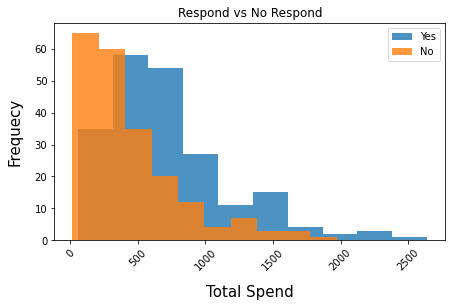

t = 7.025817159577764
p = 8.69217891293765e-12
Reject null hypothesis.
Total spend does increase with customer responding to campaign 18.


In [35]:
# Taking a sample of customers who engaged into the marketing campaigns and who did not to run hypothesis test

from scipy import stats

N = 210
camp_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==1')['monetary'].sample(N,random_state=42)
camp_not_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==0')['monetary'].sample(N,random_state=42)

fig = plt.figure(figsize=(7,4))
plt.hist(camp_converted,alpha=0.8)
plt.hist(camp_not_converted,alpha=0.8)
plt.xlabel('{}'.format('Total Spend'), size=15,labelpad=12.5)
plt.ylabel('Frequecy', size=15, labelpad=12.5)
plt.legend(['Yes','No'])
plt.xticks(rotation=45)
plt.title('Respond vs No Respond')
plt.show()
# fig.savefig('Yes_vs_No.png',transparent=False, bbox_inches='tight', dpi=300)

alpha = 0.05

t, p = stats.ttest_ind(camp_converted, camp_not_converted)
print("t = " + str(t))
print("p = " + str(p))
print_sig(p, alpha)

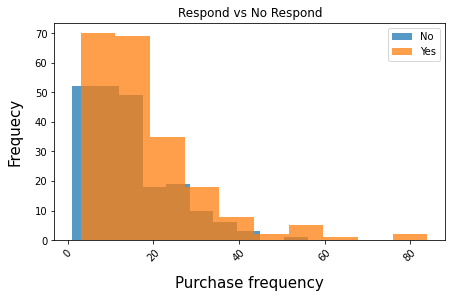

t = 4.196229628481565
p = 3.316861124990628e-05
Reject null hypothesis.
Purchase frequency does increase with customer responding to campaign 18.


In [33]:
# Taking a sample of customers who engaged into the marketing campaigns and who did not to run hypothesis test

N = 210
camp_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==1')['frequency'].sample(N,random_state=42)
camp_not_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==0')['frequency'].sample(N,random_state=42)

fig = plt.figure(figsize=(7,4))
plt.hist(camp_not_converted,alpha=0.75)
plt.hist(camp_converted,alpha=0.75)
plt.xlabel('{}'.format('Purchase frequency'), size=15,labelpad=12.5)
plt.ylabel('Frequecy', size=15, labelpad=12.5)
plt.legend(['No','Yes'])
plt.xticks(rotation=45)
plt.title('Respond vs No Respond')
plt.show()
# fig.savefig('Yes_vs_No.png',transparent=False, bbox_inches='tight', dpi=300)

alpha = 0.05

t, p = stats.ttest_ind(camp_converted, camp_not_converted)
print("t = " + str(t))
print("p = " + str(p))
print_sig(p, alpha)

In [36]:
# get all products promoted by campA 18

prod_id_camp18 = df_coupon.product_id.unique()

In [37]:
len(prod_id_camp18)

35513

In [38]:
df_promoted_prod_trans = df_trans[df_trans.product_id.isin(prod_id_camp18)]
df_promoted_prod_trans


,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2075143,2070,40533072090,587,8288358,1,0.89,311,0.00,28,85,0.0,0.0
2077704,1346,40544586146,587,564891,2,5.00,208,-1.98,1230,85,0.0,0.0
2077705,1346,40544586146,587,614196,1,5.49,208,-1.00,1230,85,0.0,0.0
2077708,1346,40544586146,587,687292,1,6.56,208,0.00,1230,85,0.0,0.0
2077709,1346,40544586146,587,740961,1,2.49,208,0.00,1230,85,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314980,36,41400725537,642,5564901,1,5.49,320,-0.80,1022,92,0.0,0.0
2314981,36,41400725537,642,5587133,10,4.00,320,0.00,1022,92,0.0,0.0
2314988,77,41400727886,642,908064,1,2.00,320,-1.29,1625,92,0.0,0.0
2314989,77,41400727886,642,10457110,1,2.00,320,-1.29,1625,92,0.0,0.0


In [43]:
df_promoted_prod_trans.to_csv('DATA_CLEAN/transactions_of_campA18_products.csv',index=False)

In [39]:
cus_id_buy_promoted_prod = df_promoted_prod_trans.household_key.unique()
len(cus_id_buy_promoted_prod)

2173

In [40]:
cus_id_campA_not_receive_converted = set(cus_id_buy_promoted_prod).intersection(set(cus_id_campA_not_receive))

cus_id_campA_not_redeemed_converted = set(cus_id_buy_promoted_prod).intersection(set(cus_id_campA_not_redeemed))

cus_id_campA_redeemed_converted = set(cus_id_buy_promoted_prod).intersection(set(cus_id_campA_redeemed))

In [41]:
len(cus_id_campA_not_receive_converted)

1077

In [42]:
len(cus_id_campA_not_redeemed_converted)

882

In [43]:
len(cus_id_campA_redeemed_converted)

214

In [44]:

df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].sales_value.sum()

71501.45999999999

### Calculate campaign 18 cost

In [45]:
total_sales_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].sales_value.sum()
total_discount_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].coupon_disc.sum()
total_match_discount_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].coupon_match_disc.sum()
total_loyalty_discount_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].retail_disc.sum()

print('Total sales from converted customers',round(total_sales_from_converted_cus,2))
print('Total coupon value discount',round(total_discount_from_converted_cus,2))
print('Total loyalty discount',round(total_loyalty_discount_from_converted_cus,2))

cost1 = abs(total_discount_from_converted_cus+total_loyalty_discount_from_converted_cus)
# ad cost of 1104 households
cost2 = 1104 * 5
cost3 = (cost1 + cost2)*0.10
total_cost = cost1 + cost2 + cost3
print('Cost - discount',cost1)
print('Cost - advertisement',cost2)
print('Cost - other',cost3)

print('Total cost',total_cost)
print('Total cost vs revenue from campaign', round(total_cost/total_sales_from_converted_cus,2))
print('ROI',round((total_sales_from_converted_cus - total_cost)/total_cost*100,2))

Total sales from converted customers 71501.46
Total coupon value discount -1163.6
Total loyalty discount -16598.52
Cost - discount 17762.12
Cost - advertisement 5520
Cost - other 2328.212
Total cost 25610.332
Total cost vs revenue from campaign 0.36
ROI 179.19


### Calculate campaign 18 revenue by marketing groups

In [46]:

# calculate total revenue value of each marketing groups
a = df_promoted_prod_trans.sales_value.sum()
b = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed)].sales_value.sum()
c = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_redeemed)].sales_value.sum()
d = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_receive)].sales_value.sum()

h = len(cus_id_campA_redeemed) / len(cus_id_campA_not_redeemed)
i = b / c

# calculate average basket value of each marketing groups during campaign time
j = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed)].groupby('basket_id').sales_value.sum().mean()
k = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_redeemed)].groupby('basket_id').sales_value.sum().mean()
l = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_receive)].groupby('basket_id').sales_value.sum().mean()

# calculate average frequency of each marketing groups during campaign time
m = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed)].groupby('household_key').basket_id.nunique().mean()
n = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_redeemed)].groupby('household_key').basket_id.nunique().mean()
o = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_receive)].groupby('household_key').basket_id.nunique().mean()
m = round(m,2)
n = round(n,2)
o = round(o,2)

print('Total revenue from campaign18', round(a,2))
print('Total revenue from customers with redemption', round(b,2))
print('Total revenue from customers who did not redeem', round(c,2))
print('Total revenue from customers who did not receive offers', round(d,2))

print(f'Sale ratio of converted vs non-converted {round(i,2)}')
print(f'Household ratio of converted vs non-converted {round(h,2)}')




Total revenue from campaign18 350833.49
Total revenue from customers with redemption 71501.46
Total revenue from customers who did not redeem 174646.94
Total revenue from customers who did not receive offers 104685.09
Sale ratio of converted vs non-converted 0.41
Household ratio of converted vs non-converted 0.23


In [47]:
data = {'group':['Redeemed','Did not redeem','Did not receive offers'],
        'household_count':[len(cus_id_campA_redeemed),len(cus_id_campA_not_redeemed),len(cus_id_campA_not_receive)],
        'revenue':[b,c,d],
        'mean_basket_value':[j,k,l],
        'mean_frequency':[m,n,o]}

revenue_df = pd.DataFrame.from_dict(data)
revenue_df

,group,household_count,revenue,mean_basket_value,mean_frequency
0,Redeemed,214,71501.46,24.562508,13.60
1,Did not redeem,919,174646.94,19.306538,10.26
2,Did not receive offers,1133,104685.09,18.710472,5.19


In [48]:
revenue_df['household_ratio'] = round(revenue_df.household_count / revenue_df.household_count.sum(),2)
revenue_df['revenue_ratio'] = round(revenue_df.revenue / revenue_df.revenue.sum(),2)
revenue_df

,group,household_count,revenue,mean_basket_value,mean_frequency,household_ratio,revenue_ratio
0,Redeemed,214,71501.46,24.562508,13.60,0.09,0.2
1,Did not redeem,919,174646.94,19.306538,10.26,0.41,0.5
2,Did not receive offers,1133,104685.09,18.710472,5.19,0.50,0.3


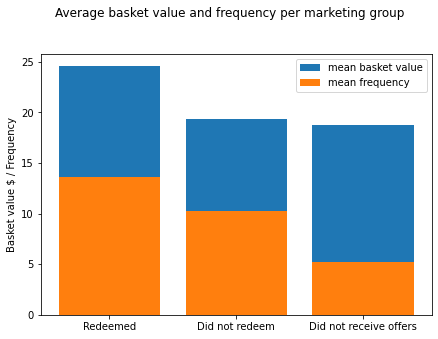

In [49]:
fig = plt.figure(figsize=(7,5))
fig.subplots_adjust(hspace=0.9, wspace=0.9, top=0.85)
    
plt.bar(revenue_df.group, revenue_df.mean_basket_value, label='mean basket value')
plt.bar(revenue_df.group, revenue_df.mean_frequency, label='mean frequency')

plt.legend()
# plt.xlabel('Marketing groups')
plt.ylabel('Basket value $ / Frequency')
fig.suptitle('Average basket value and frequency per marketing group')
plt.show()

In [50]:
df_household

,household_key,recency,frequency,monetary,rfm_group,rfm_score,segment,received_campA_18,redeemed_campA_18,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,MEAT_spend
0,2375,3,17,466.49,343,10,Loyal,1,1,173.75,NaN,65.80,NaN,62.36,68.50
1,1364,0,12,182.92,432,9,Loyal,1,0,82.94,9.17,16.27,NaN,12.86,29.25
2,1130,0,24,453.98,443,11,Champions,1,1,259.16,17.66,43.22,NaN,51.38,49.99
3,1173,5,2,55.90,211,4,Required activation,0,0,44.92,NaN,NaN,NaN,4.99,NaN
4,98,1,50,658.15,444,12,Champions,0,0,519.24,5.99,8.06,NaN,72.92,6.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,338,1,13,189.35,432,9,Loyal,0,0,109.42,NaN,21.39,NaN,55.55,NaN
2233,615,4,4,107.45,212,5,Required activation,0,0,21.23,17.41,17.17,NaN,10.78,31.70
2234,1077,1,10,495.03,434,11,Champions,0,0,279.83,NaN,12.35,107.03,27.83,23.37
2235,1581,3,6,299.99,323,8,Need attention,1,1,223.76,NaN,16.74,NaN,12.73,11.53


In [51]:
household_duringCamp18 = df_household[['household_key','received_campA_18','redeemed_campA_18']]
household_duringCamp18

,household_key,received_campA_18,redeemed_campA_18
0,2375,1,1
1,1364,1,0
2,1130,1,1
3,1173,0,0
4,98,0,0
...,...,...,...
2232,338,0,0
2233,615,0,0
2234,1077,0,0
2235,1581,1,1


In [180]:
household_beforeCamp18 = pd.read_csv('DATA_CLEAN/households_beforeCamp18.csv')
household_beforeCamp18

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,revenue,recency,frequency,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,recency_cluster,frequency_cluster,revenue_cluster,rfm_score,segment
0,1,1,1,4.0,2.0,2.0,0.0,3.0,80.0,3.0,0.75,0.04,3362.46,5,67,2158.21,158.50,206.80,0.00,374.38,43.64,12.69,17.91,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value
1,16,1,0,2.0,1.0,1.0,0.0,0.0,32.0,0.0,0.00,0.00,1471.45,4,92,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value
2,25,1,0,3.0,3.0,0.0,0.0,0.0,48.0,0.0,0.00,0.00,2739.20,6,76,1271.37,37.72,103.08,35.00,921.90,1.00,10.29,110.97,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value
3,71,1,0,1.0,1.0,0.0,0.0,0.0,16.0,0.0,0.00,0.00,2991.04,6,76,805.14,23.20,128.71,30.00,1568.06,1.00,26.72,182.04,35-44,A,25-34K,Homeowner,Single Female,2,None/Unknown,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value
4,114,1,0,3.0,3.0,0.0,0.0,0.0,48.0,0.0,0.00,0.00,2580.29,7,72,1400.94,8.52,74.80,135.28,342.83,111.69,2.55,87.42,25-34,U,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2322,1,1,7.0,2.0,4.0,1.0,3.0,90.0,3.0,0.43,0.03,20222.99,3,265,6619.57,802.70,2584.54,66.70,4532.86,668.17,19.74,820.90,45-54,U,175-199K,Homeowner,Single Male,1,None/Unknown,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,3,2,3,8,High-value
797,2351,1,1,6.0,2.0,3.0,1.0,7.0,119.0,7.0,1.17,0.06,12920.20,2,265,6043.77,465.22,1219.36,2161.37,980.03,60.01,0.00,719.77,45-54,A,75-99K,Homeowner,2 Adults No Kids,2,None/Unknown,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,2,3,8,High-value
798,718,1,1,10.0,3.0,5.0,2.0,4.0,179.0,4.0,0.40,0.02,16518.81,0,538,8563.79,387.36,1067.03,995.00,1875.42,327.80,10.85,782.03,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,3,3,3,9,High-value
799,900,1,0,5.0,2.0,3.0,0.0,0.0,64.0,0.0,0.00,0.00,13185.08,0,994,4550.80,816.53,487.56,2431.82,2680.25,54.75,119.87,568.30,35-44,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,9,High-value


In [181]:
household_beforeCamp18 = household_beforeCamp18.merge(household_duringCamp18,on='household_key')
household_beforeCamp18

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,revenue,recency,frequency,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,recency_cluster,frequency_cluster,revenue_cluster,rfm_score,segment,received_campA_18,redeemed_campA_18
0,1,1,1,4.0,2.0,2.0,0.0,3.0,80.0,3.0,0.75,0.04,3362.46,5,67,2158.21,158.50,206.80,0.00,374.38,43.64,12.69,17.91,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value,1,1
1,16,1,0,2.0,1.0,1.0,0.0,0.0,32.0,0.0,0.00,0.00,1471.45,4,92,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value,0,0
2,25,1,0,3.0,3.0,0.0,0.0,0.0,48.0,0.0,0.00,0.00,2739.20,6,76,1271.37,37.72,103.08,35.00,921.90,1.00,10.29,110.97,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value,1,0
3,71,1,0,1.0,1.0,0.0,0.0,0.0,16.0,0.0,0.00,0.00,2991.04,6,76,805.14,23.20,128.71,30.00,1568.06,1.00,26.72,182.04,35-44,A,25-34K,Homeowner,Single Female,2,None/Unknown,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value,1,0
4,114,1,0,3.0,3.0,0.0,0.0,0.0,48.0,0.0,0.00,0.00,2580.29,7,72,1400.94,8.52,74.80,135.28,342.83,111.69,2.55,87.42,25-34,U,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,Low-value,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,2322,1,1,7.0,2.0,4.0,1.0,3.0,90.0,3.0,0.43,0.03,20222.99,3,265,6619.57,802.70,2584.54,66.70,4532.86,668.17,19.74,820.90,45-54,U,175-199K,Homeowner,Single Male,1,None/Unknown,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,3,2,3,8,High-value,0,0
790,2351,1,1,6.0,2.0,3.0,1.0,7.0,119.0,7.0,1.17,0.06,12920.20,2,265,6043.77,465.22,1219.36,2161.37,980.03,60.01,0.00,719.77,45-54,A,75-99K,Homeowner,2 Adults No Kids,2,None/Unknown,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,2,3,8,High-value,1,1
791,718,1,1,10.0,3.0,5.0,2.0,4.0,179.0,4.0,0.40,0.02,16518.81,0,538,8563.79,387.36,1067.03,995.00,1875.42,327.80,10.85,782.03,45-54,A,25-34K,Homeowner,2 Adults Kids,5+,3+,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,3,3,3,9,High-value,1,1
792,900,1,0,5.0,2.0,3.0,0.0,0.0,64.0,0.0,0.00,0.00,13185.08,0,994,4550.80,816.53,487.56,2431.82,2680.25,54.75,119.87,568.30,35-44,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,9,High-value,1,0


In [185]:
household_beforeCamp18.groupby('segment').received_campA_18.sum()


segment
High-value     47
Low-value     287
Mid-value     303
Name: received_campA_18, dtype: int64

In [186]:
household_beforeCamp18.groupby('segment').redeemed_campA_18.sum()

segment
High-value    18
Low-value     64
Mid-value     84
Name: redeemed_campA_18, dtype: int64

In [52]:
household_beforeCamp18_full = pd.read_csv('DATA_CLEAN/households_withoutDemographic_beforeCamp18_02.csv')
household_beforeCamp18_full.head()

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11,0,83,1985.72,433,10,Loyal,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90,36,39,599.87,121,4,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [53]:
household_beforeCamp18_full = household_beforeCamp18_full.merge(household_duringCamp18,on='household_key')
household_beforeCamp18_full

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,received_campA_18,redeemed_campA_18
0,2375,1,1,1.0,1.0,0.0,0.0,8.0,16.0,8.0,8.00,0.50,958.60,73.63,266.52,0.00,208.87,0.00,7.50,321.11,0,83,1985.72,433,10,Loyal,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1364,1,1,4.0,3.0,1.0,0.0,1.0,61.0,1.0,0.25,0.02,980.43,121.29,107.73,0.00,272.63,2.77,98.18,196.76,0,120,2050.37,443,11,Champions,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1130,1,0,5.0,4.0,0.0,1.0,0.0,98.0,0.0,0.00,0.00,2451.56,355.96,418.60,20.00,652.72,39.29,19.33,540.69,0,303,5150.75,444,12,Champions,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
3,1173,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,205.07,1.95,24.65,153.35,157.15,5.00,0.00,17.90,36,39,599.87,121,4,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,98,1,0,2.0,1.0,0.0,1.0,0.0,50.0,0.0,0.00,0.00,996.03,10.69,65.59,0.00,158.05,21.12,0.00,96.90,0,112,1429.81,432,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,540,1,0,1.0,1.0,0.0,0.0,0.0,16.0,0.0,0.00,0.00,844.63,37.95,397.94,107.95,182.89,257.49,6.16,63.77,3,65,1983.79,333,9,Loyal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2232,338,1,0,2.0,2.0,0.0,0.0,0.0,32.0,0.0,0.00,0.00,609.01,17.93,414.26,0.00,117.02,2.99,0.00,396.80,7,103,1647.43,232,7,Need attention,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2233,615,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,42.39,0.00,15.54,86.47,11.27,4.26,0.00,2.15,37,11,180.54,111,3,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2234,1077,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,299.99,22.34,18.34,52.48,79.09,0.00,0.00,33.28,2,16,550.48,311,5,Required activation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
household_beforeCamp18_full.groupby('segment').received_campA_18.sum()


segment
Champions              441
Loyal                  388
Need attention         253
Required activation     22
Name: received_campA_18, dtype: int64

In [55]:
household_beforeCamp18_full.groupby('segment').redeemed_campA_18.sum()

segment
Champions              110
Loyal                   67
Need attention          34
Required activation      3
Name: redeemed_campA_18, dtype: int64

In [56]:
data = {'segment':['Required activation','Need attention','Loyal','Champions'],
        'received_camp18_coupons':[22, 253,388,441],
        'redeemed_camp18_coupons':[3,34,67,110],
        }

segment_df = pd.DataFrame.from_dict(data)
segment_df

,segment,received_camp18_coupons,redeemed_camp18_coupons
0,Required activation,22,3
1,Need attention,253,34
2,Loyal,388,67
3,Champions,441,110


In [57]:
segment_df['redemption_ratio'] = round(segment_df.redeemed_camp18_coupons / segment_df.received_camp18_coupons,2)
segment_df['received_ratio'] = round(segment_df.received_camp18_coupons / sum(segment_df.received_camp18_coupons),2)

In [58]:
segment_df

,segment,received_camp18_coupons,redeemed_camp18_coupons,redemption_ratio,received_ratio
0,Required activation,22,3,0.14,0.02
1,Need attention,253,34,0.13,0.23
2,Loyal,388,67,0.17,0.35
3,Champions,441,110,0.25,0.40


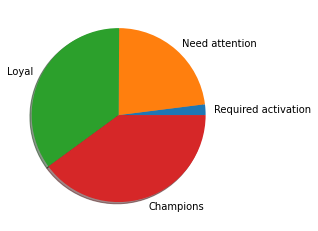

In [59]:
y = segment_df.received_camp18_coupons
labels_setting = ['Required activation','Need attention','Loyal','Champions']

plt.pie(y, labels = labels_setting, shadow = True)
plt.show() 

<BarContainer object of 4 artists>

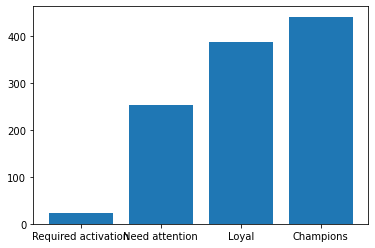

In [60]:

plt.bar(segment_df.segment, segment_df.received_camp18_coupons)


<BarContainer object of 4 artists>

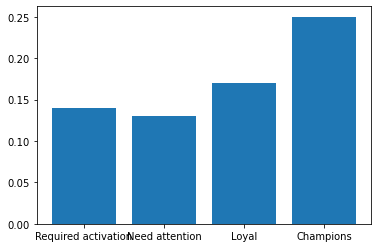

In [61]:
plt.bar(segment_df.segment, segment_df.redemption_ratio)

In [62]:
household_full = pd.read_csv('DATA_CLEAN/households_full_02.csv')
household_full.head()

,household_key,received_campaign,redeemed_coupons,total_campaigns_received,TypeA,TypeB,TypeC,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,recency,frequency,monetary,rfm_group,rfm_score,segment,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1,1,1,8.0,3.0,4.0,1.0,5.0,159.0,5.0,0.62,0.03,2755.00,212.17,266.10,0.00,530.89,48.33,41.20,17.91,5,86,4330.16,333,9,Loyal,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,2,1,0,1.0,1.0,0.0,0.0,0.0,16.0,0.0,0.00,0.00,1112.49,46.73,152.28,0.00,330.04,7.47,0.00,154.32,43,45,1954.34,122,5,Required activation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,0,3.0,2.0,0.0,1.0,0.0,58.0,0.0,0.00,0.00,1784.75,36.47,68.03,20.01,159.08,0.00,1.36,317.27,8,47,2653.21,223,7,Need attention,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,0,1.0,1.0,0.0,0.0,0.0,16.0,0.0,0.00,0.00,698.73,14.35,4.87,0.00,318.98,3.29,0.00,38.74,84,30,1200.11,112,4,Required activation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,359.13,80.03,2.19,0.00,203.08,2.00,0.00,49.75,8,40,779.06,221,5,Required activation,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
household_full.groupby('segment').received_campaign.sum()

segment
Champions              484
Loyal                  481
Need attention         517
Required activation    102
Name: received_campaign, dtype: int64

In [64]:
household_full.groupby('segment').redeemed_coupons.sum()

segment
Champions              226
Loyal                  120
Need attention          82
Required activation      6
Name: redeemed_coupons, dtype: int64

In [65]:
data = {'segment':['Required activation','Need attention','Loyal','Champions'],
        'received_coupons':[102,517,481,484],
        'redeemed_coupons':[6,82,120,226],
        }

segment_df_full = pd.DataFrame.from_dict(data)
segment_df_full['redemption_ratio'] = round(segment_df_full.redeemed_coupons / segment_df_full.received_coupons,2)
segment_df_full['received_ratio'] = round(segment_df_full.received_coupons / sum(segment_df_full.received_coupons),2)
segment_df_full

,segment,received_coupons,redeemed_coupons,redemption_ratio,received_ratio
0,Required activation,102,6,0.06,0.06
1,Need attention,517,82,0.16,0.33
2,Loyal,481,120,0.25,0.30
3,Champions,484,226,0.47,0.31


<BarContainer object of 4 artists>

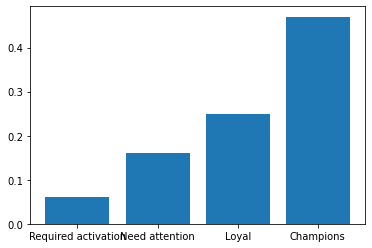

In [66]:

plt.bar(segment_df_full.segment, segment_df_full.redemption_ratio)


<BarContainer object of 4 artists>

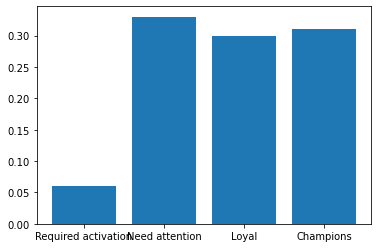

In [67]:
plt.bar(segment_df_full.segment, segment_df_full.received_ratio)